# XGBoost Model Training for Stock Price Prediction

## Objective
This notebook trains XGBoost models to predict stock prices at three different time horizons:
1. Next day closing price
2. Next week average price (5 trading days)
3. Next month average price (21 trading days)

We'll use a sliding window approach with a 30-day prediction window to generate more realistic evaluations of model performance.

## Steps:
1. Import necessary libraries
2. Define helper functions for data loading
3. Implement sliding window training approach
4. Train models for each prediction horizon
5. Save trained models

Each stock will have three separate models, allowing for specialized predictions across different time frames.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import xgboost as xgb
import joblib
from glob import glob
import warnings

# Set display options
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
%matplotlib inline

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

## Define Input and Output Directories

In [2]:
# Define input and output directories
input_dir = '../data/xgboost/'
output_dir = '../model/xgboost/'

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

print(f"Input directory: {input_dir}")
print(f"Output directory: {output_dir}")

Input directory: ../data/xgboost/
Output directory: ../model/xgboost/


## Helper Functions for Data Loading

In [3]:
def load_stock_data():
    """
    Load all XGBoost-prepared stock data files from the input directory.

    Returns:
    - Dictionary containing dataframes for each stock
    """
    stock_data = {}
    csv_files = glob(os.path.join(input_dir, '*_xgboost.csv'))

    print(f"Found {len(csv_files)} CSV files in {input_dir}")

    for file_path in csv_files:
        # Extract stock symbol from filename
        stock_symbol = os.path.basename(file_path).split('_')[0]

        # Load the CSV file
        try:
            df = pd.read_csv(file_path)
            # Ensure 'date' column is datetime
            df['date'] = pd.to_datetime(df['date'])
            # Sort by date to ensure chronological order for sliding window
            df = df.sort_values('date').reset_index(drop=True)

            # Add to dictionary
            stock_data[stock_symbol] = df
            print(f"Loaded {stock_symbol}: {df.shape[0]} rows, {df.shape[1]} columns")
        except Exception as e:
            print(f"Error loading {file_path}: {str(e)}")

    return stock_data

## Define Feature Selection Function

This function extracts the relevant features for model training.

In [4]:
def get_features(df):
    """
    Select features for model training from the dataframe.
    
    Parameters:
    - df: DataFrame with stock data
    
    Returns:
    - List of feature columns available in the dataframe
    """
    # Define potential features based on the preparation notebook
    potential_features = [
        # Price-based features
        'close', 'return', 'price_change_pct', 'daily_range_pct', 'price_position',
        
        # Trend indicators
        'dist_from_ma5', 'dist_from_ma20', 'dist_from_ma50', 'ma5_gt_ma20', 'ma20_gt_ma50',
        
        # Volume indicators
        'volume_change', 'relative_volume',
        
        # Momentum indicators
        'momentum_3d', 'momentum_5d', 'momentum_10d',
        
        # Technical indicators
        'rsi_14', 'bb_width', 'bb_position',
        
        # Lag features
        'prev_close', 'prev_volume', 'prev_return',
        
        # Cyclical time features
        'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos'
    ]
    
    # Only include features that exist in the dataframe
    available_features = [col for col in potential_features if col in df.columns]
    
    print(f"Using {len(available_features)} features for training")
    print(f"Features: {available_features}")
    
    return available_features

## Sliding Window Training Function

This function implements a sliding window approach for training and evaluating models. Rather than a single train/test split, we'll train on 90% of the data and then slide the window forward to generate predictions.

In [5]:
def train_with_sliding_window(df, features, target_column, period, window_size=30):
    """
    Train an XGBoost model using a sliding window approach.
    
    Parameters:
    - df: DataFrame with stock data
    - features: List of feature columns
    - target_column: Target variable to predict
    - period: Prediction period (day, week, or month)
    - window_size: Size of the prediction window in days
    
    Returns:
    - Trained XGBoost model
    """
    print(f"Training {period} model with sliding window approach...")
    
    # Get features and target
    X = df[features]
    y = df[target_column]
    
    # Calculate the initial training size (90% of data)
    train_size = int(len(df) * 0.9)
    
    # For the final model, train on all but the last window_size days
    X_train = X.iloc[:train_size]
    y_train = y.iloc[:train_size]
    
    # Set XGBoost parameters
    params = {
        'objective': 'reg:squarederror',  # Regression task
        'eval_metric': 'rmse',           # Evaluation metric
        'n_jobs': -1,                    # Use all CPU cores
        'tree_method': 'hist',           # Faster algorithm
        'random_state': 42,              # For reproducibility
        
        # Parameters for different prediction periods
        'learning_rate': 0.05 if period == 'day' else (0.03 if period == 'week' else 0.02),
        'n_estimators': 200 if period == 'day' else (300 if period == 'week' else 400),
        'max_depth': 6 if period == 'day' else (6 if period == 'week' else 5),
        'subsample': 0.8 if period != 'month' else 0.7,
        'colsample_bytree': 0.8 if period != 'month' else 0.7
    }
    
    # Train the final model on all training data
    print(f"Training final model for {period} prediction with {params['n_estimators']} trees")
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, verbose=False)
    
    # Get feature importance
    importance = model.feature_importances_
    feature_importance = pd.DataFrame({
        'Feature': features,
        'Importance': importance
    }).sort_values('Importance', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
    plt.title(f'Top 15 Features - {period.capitalize()} Model')
    plt.tight_layout()
    plt.show()
    
    return model, feature_importance

## Load Stock Data

In [ ]:
# Load stock data
stock_data = load_stock_data()
print(f"Loaded data for {len(stock_data)} stocks")

## Train Models for Each Stock and Prediction Period

Now we'll train XGBoost models for each stock and each prediction period (day, week, month) using our sliding window approach.

In [ ]:
# Define prediction periods and corresponding target columns
periods = {
    'day': 'next_day_close',
    'week': 'next_week_avg',
    'month': 'next_month_avg'
}

# Train models for each stock and period
for ticker, df in stock_data.items():
    print(f"\n{'='*50}")
    print(f"Training models for {ticker}")
    print(f"{'='*50}")
    
    # Get features for this stock
    features = get_features(df)
    
    # Train a model for each prediction period
    for period, target_column in periods.items():
        print(f"\n{'-'*50}")
        print(f"Training {period} prediction model for {ticker}")
        print(f"{'-'*50}")
        
        # Train model with sliding window
        model, feature_importance = train_with_sliding_window(
            df, features, target_column, period
        )
        
        # Save model
        model_filename = os.path.join(output_dir, f"xgboost_{ticker}_{period}.joblib")
        joblib.dump(model, model_filename)
        print(f"Model saved to {model_filename}")
        
        # Save feature importance
        importance_filename = os.path.join(output_dir, f"xgboost_{ticker}_{period}_importance.csv")
        feature_importance.to_csv(importance_filename, index=False)
        
        # Save list of features used
        features_filename = os.path.join(output_dir, f"xgboost_{ticker}_{period}_features.txt")
        with open(features_filename, 'w') as f:
            f.write('\n'.join(features))
        
        print(f"Completed {period} model for {ticker}")

print("\nAll models trained and saved successfully!")


Evaluating T day model...

Performance metrics for T day model:
MSE: 43.2360
RMSE: 6.5754
MAE: 6.3237
R2: -13.6045
MAPE: 24.3644
Direction Accuracy: 55.0000


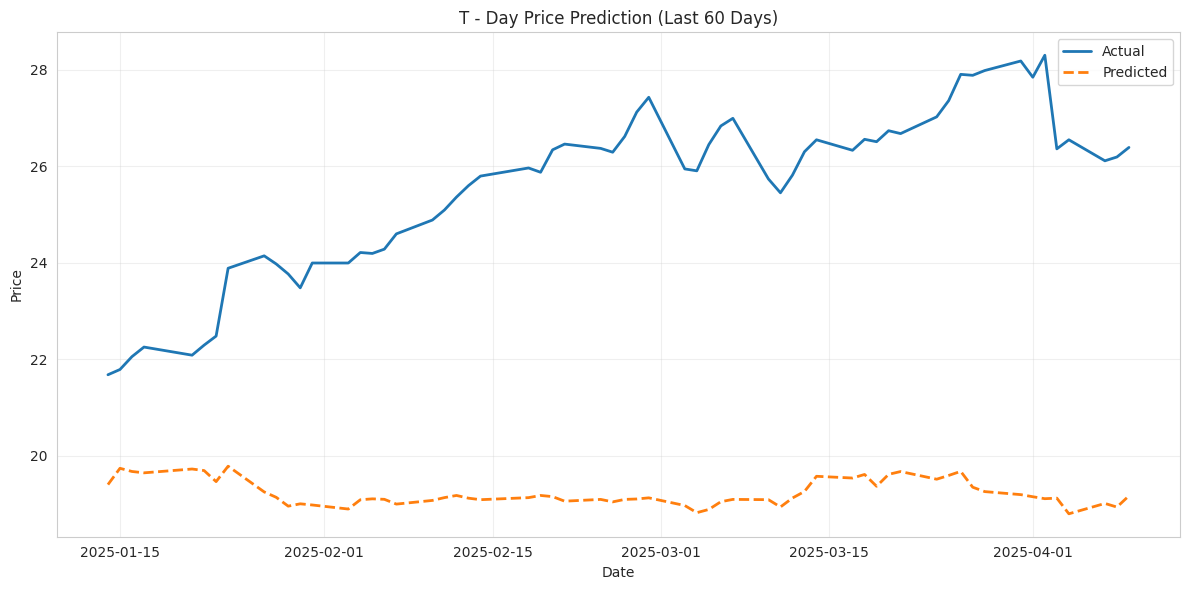

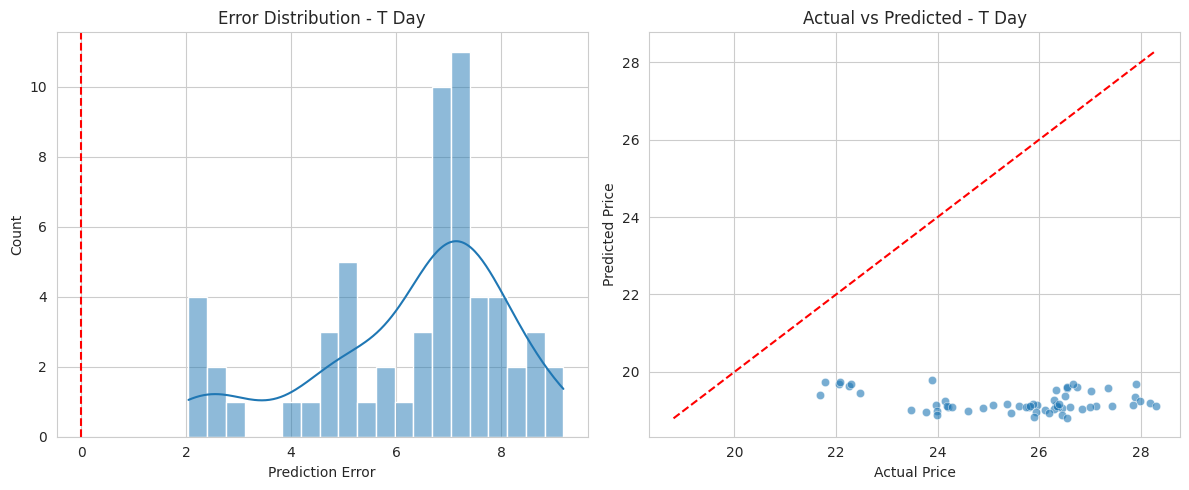


Evaluating T week model...

Performance metrics for T week model:
MSE: 54.0105
RMSE: 7.3492
MAE: 7.1254
R2: -21.8460
MAPE: 27.3658
Direction Accuracy: 63.3333


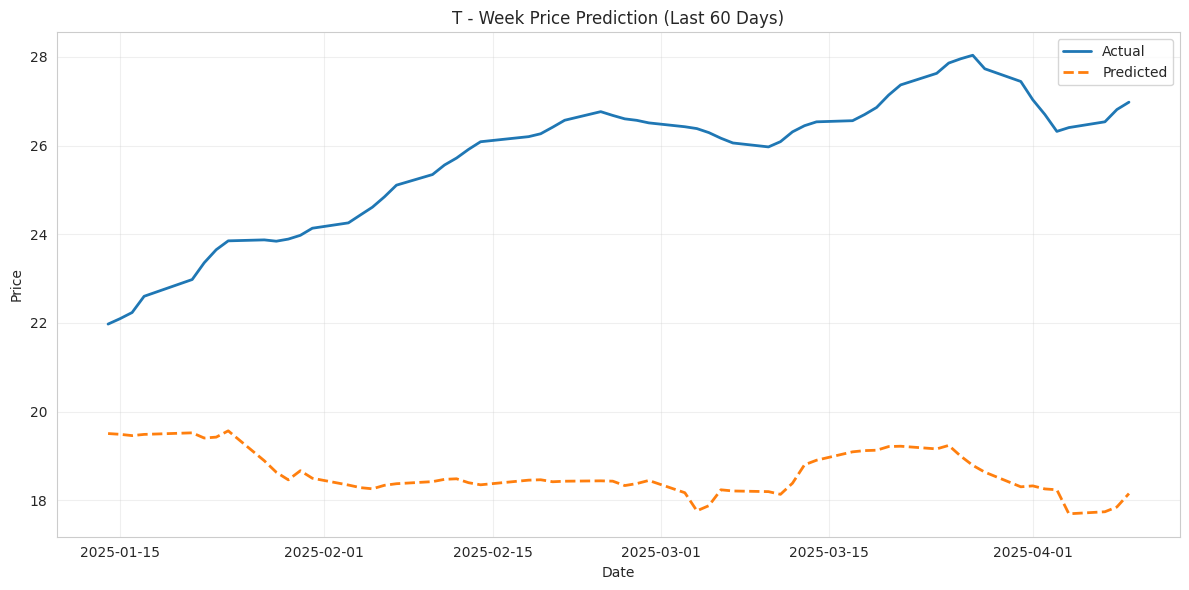

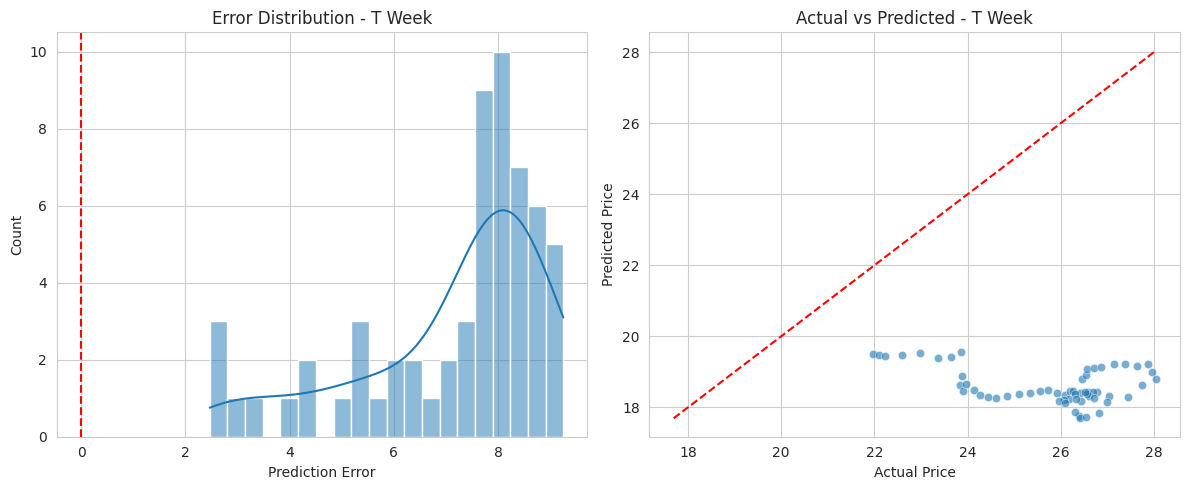


Evaluating T month model...

Performance metrics for T month model:
MSE: 74.8872
RMSE: 8.6537
MAE: 8.5072
R2: -74.4356
MAPE: 32.2017
Direction Accuracy: 50.0000


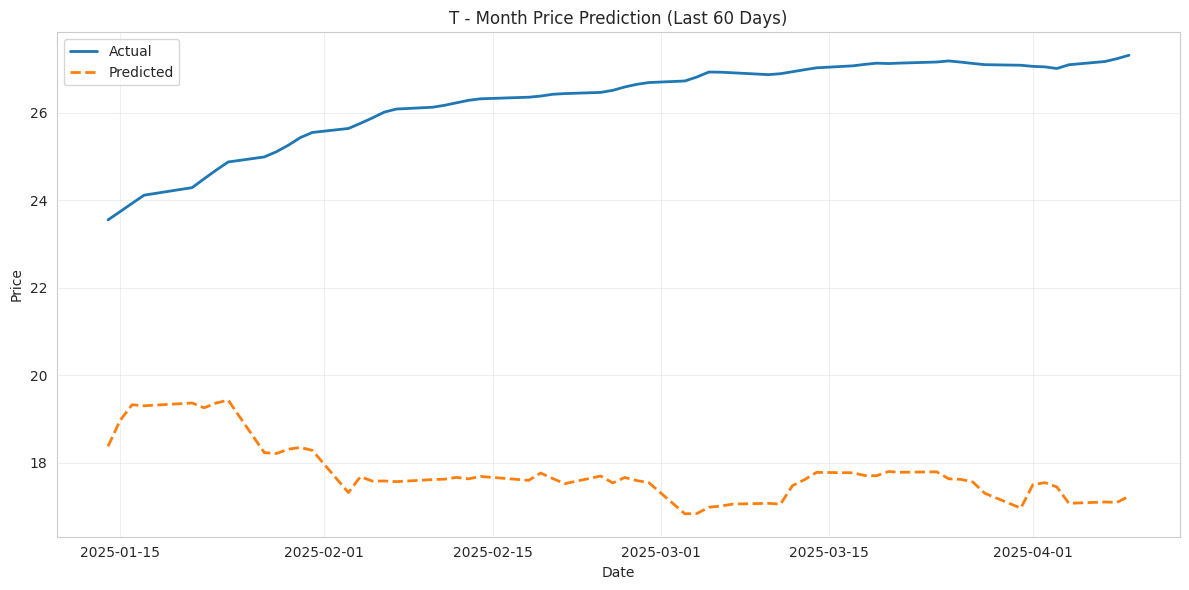

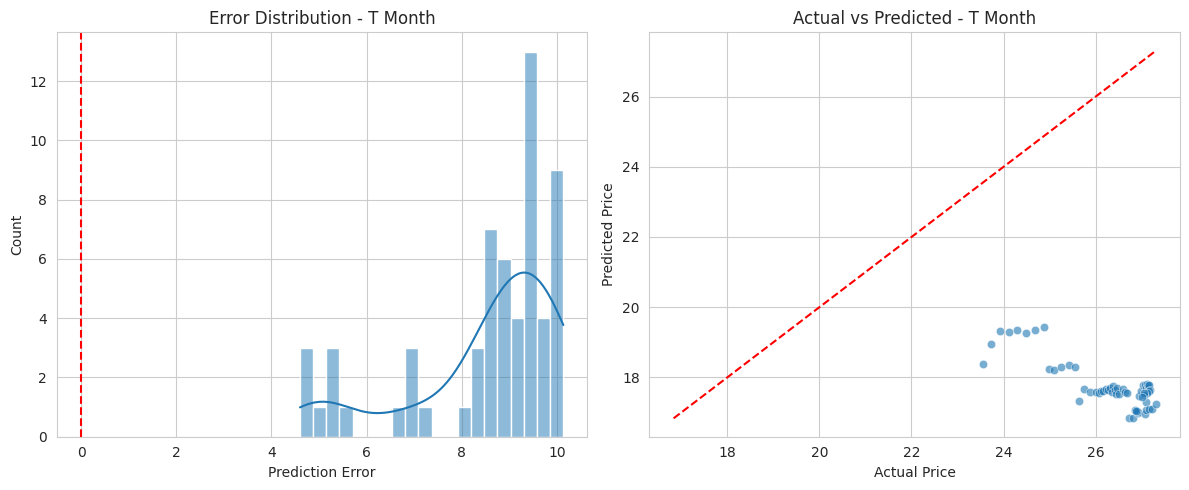


Evaluating SPY day model...

Performance metrics for SPY day model:
MSE: 6385.5663
RMSE: 79.9097
MAE: 75.3334
R2: -7.5898
MAPE: 12.8159
Direction Accuracy: 43.3333


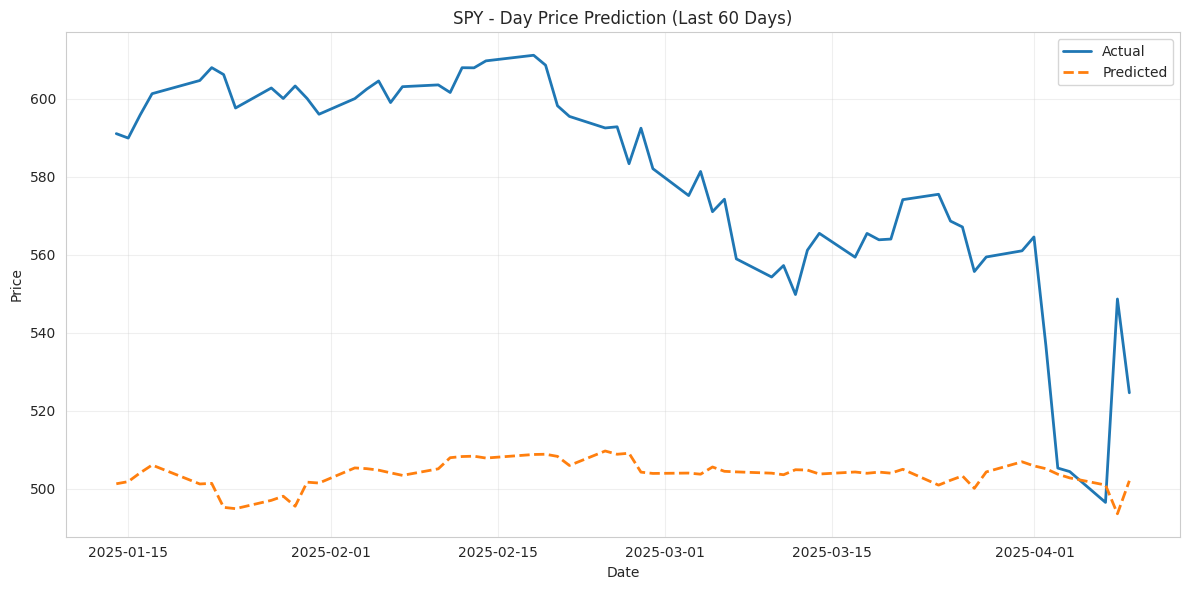

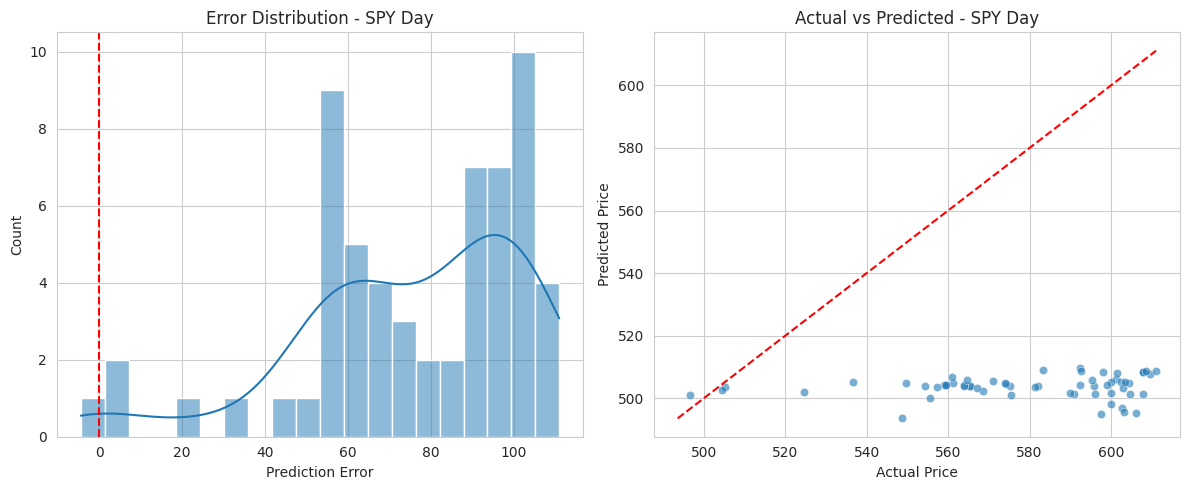


Evaluating SPY week model...

Performance metrics for SPY week model:
MSE: 6897.2505
RMSE: 83.0497
MAE: 78.9132
R2: -8.6012
MAPE: 13.4929
Direction Accuracy: 55.0000


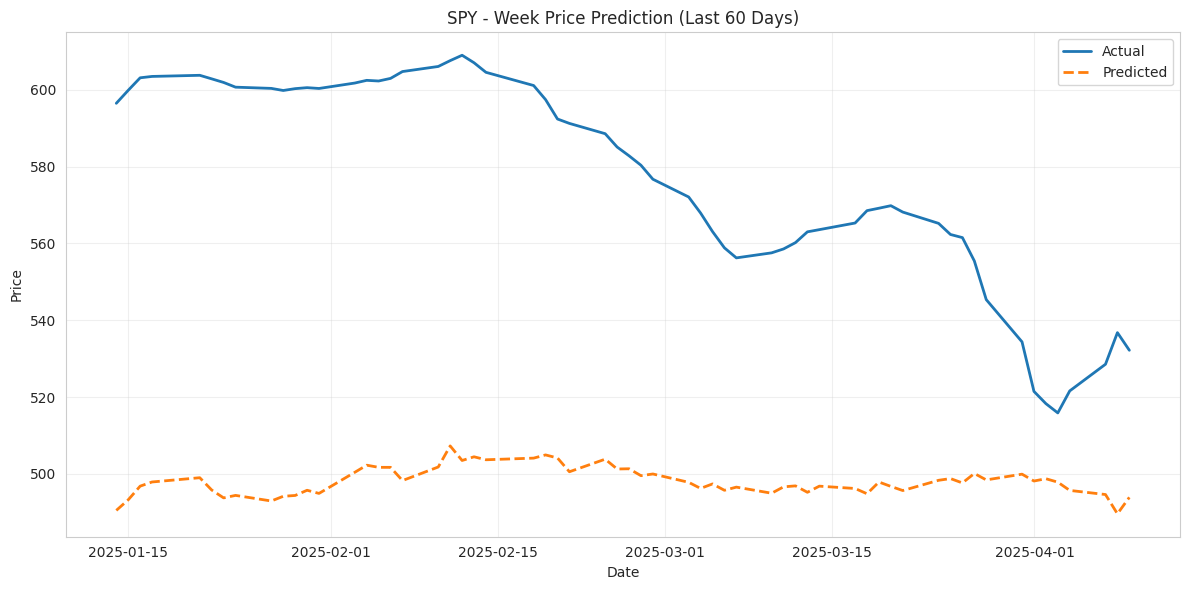

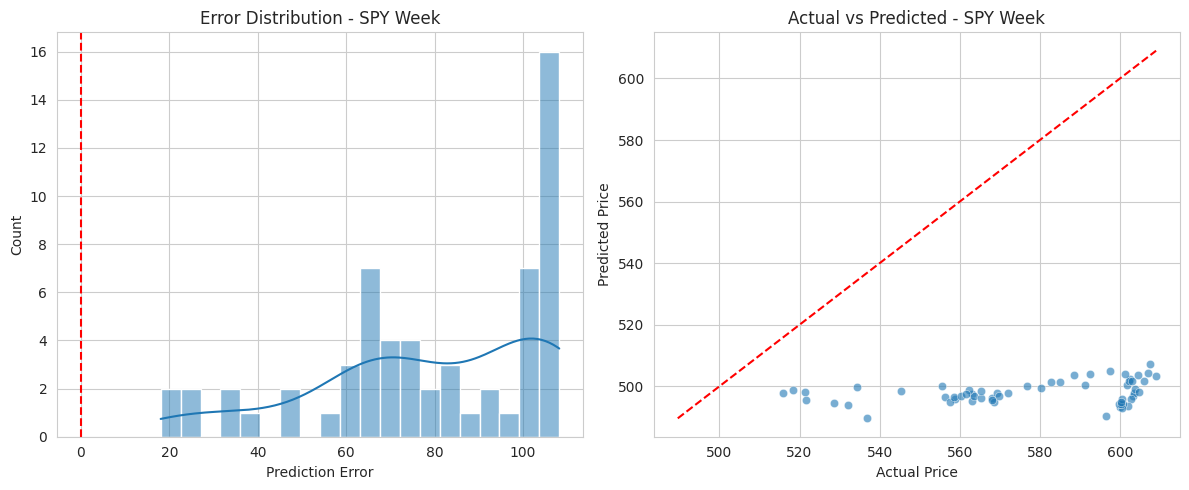


Evaluating SPY month model...

Performance metrics for SPY month model:
MSE: 5807.2865
RMSE: 76.2056
MAE: 72.3088
R2: -8.6279
MAPE: 12.5524
Direction Accuracy: 48.3333


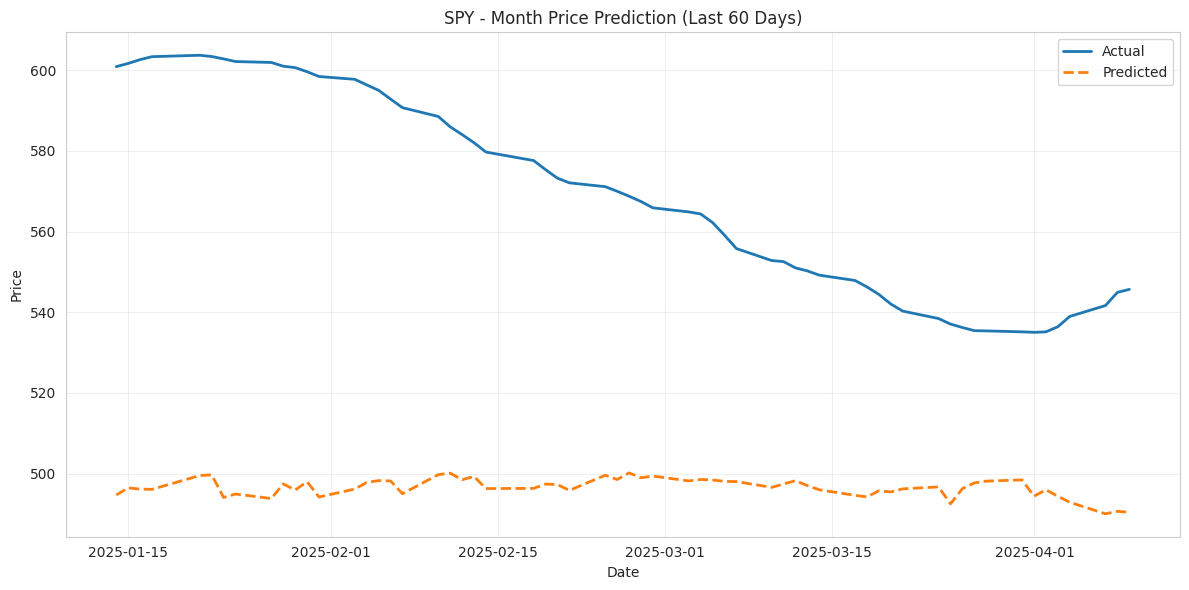

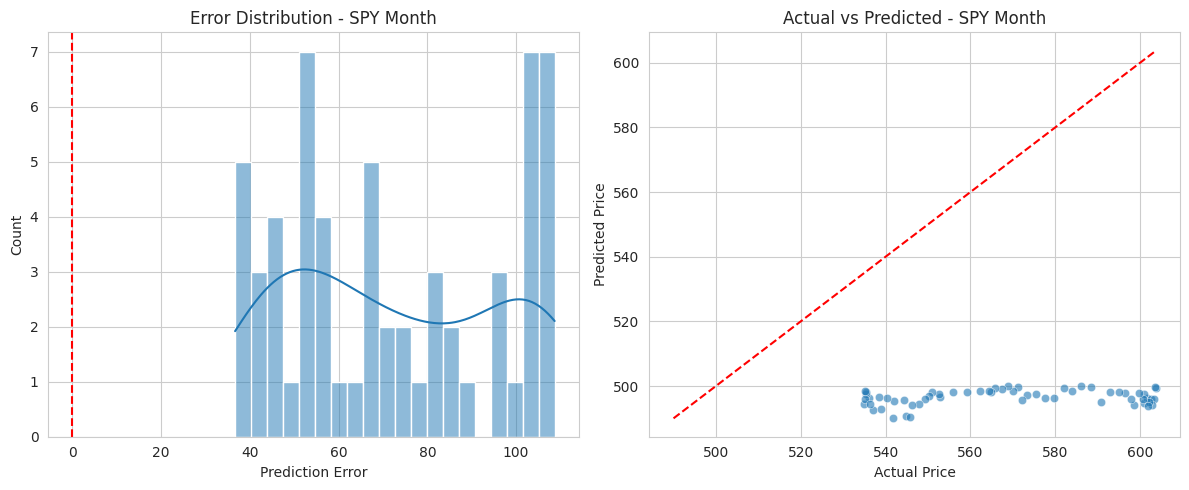


Evaluating GS day model...

Performance metrics for GS day model:
MSE: 43722.9391
RMSE: 209.1003
MAE: 202.9150
R2: -14.5812
MAPE: 33.8203
Direction Accuracy: 61.6667


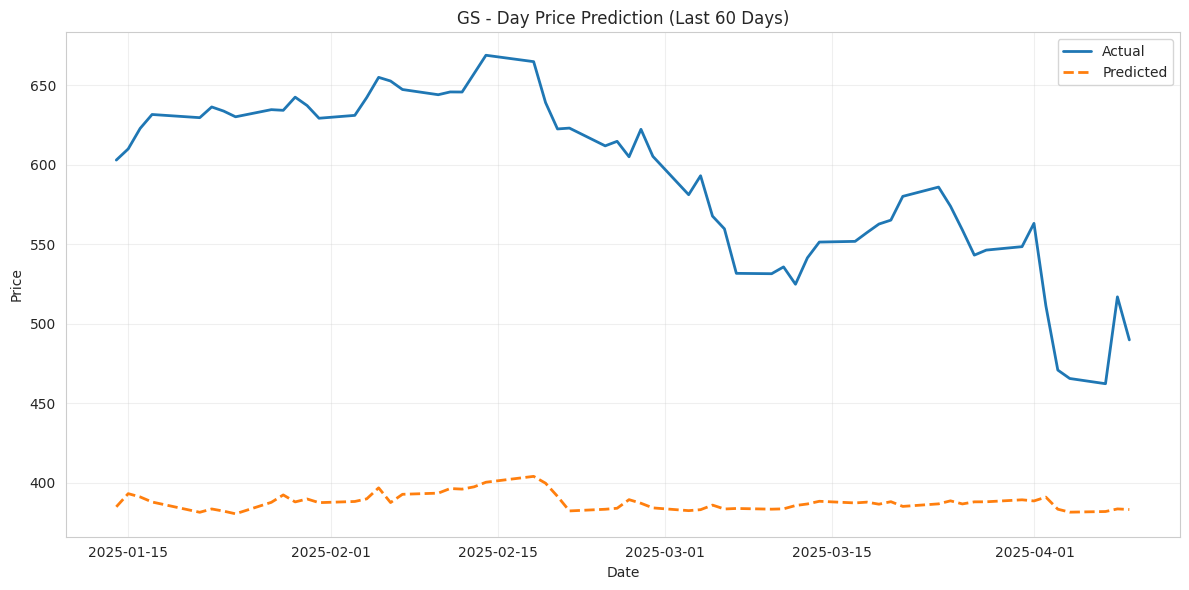

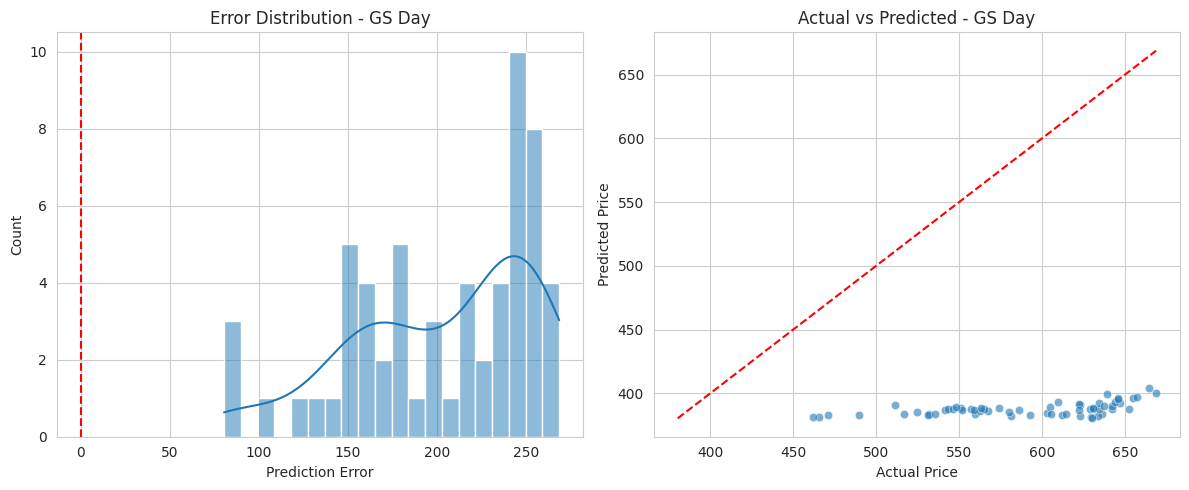


Evaluating GS week model...

Performance metrics for GS week model:
MSE: 43390.4975
RMSE: 208.3039
MAE: 201.5770
R2: -14.2783
MAPE: 33.7830
Direction Accuracy: 55.0000


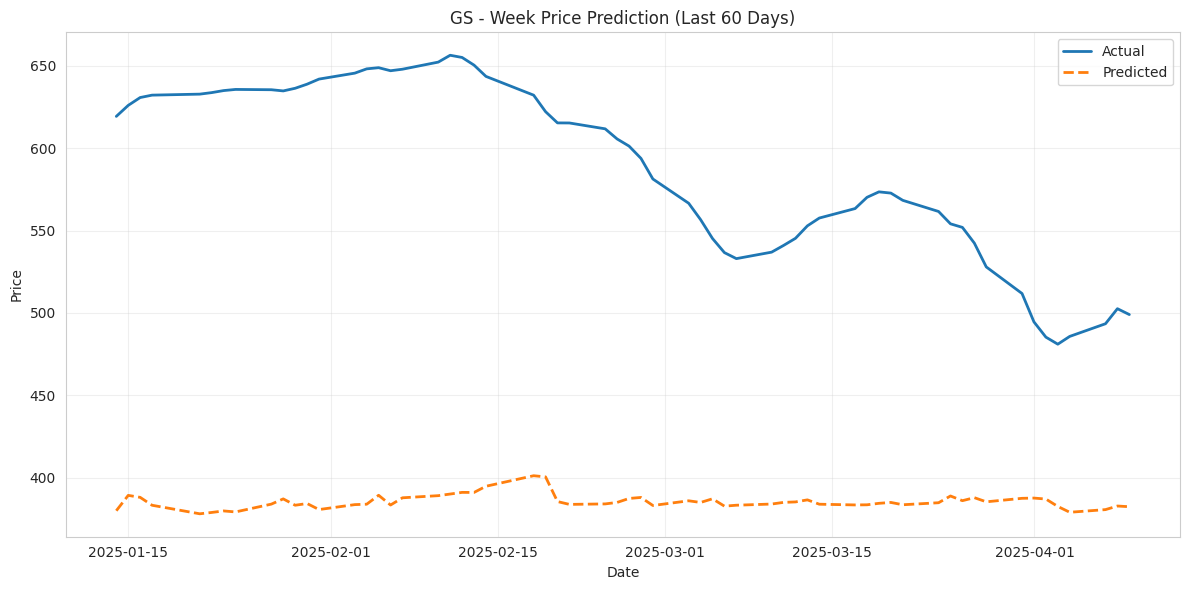

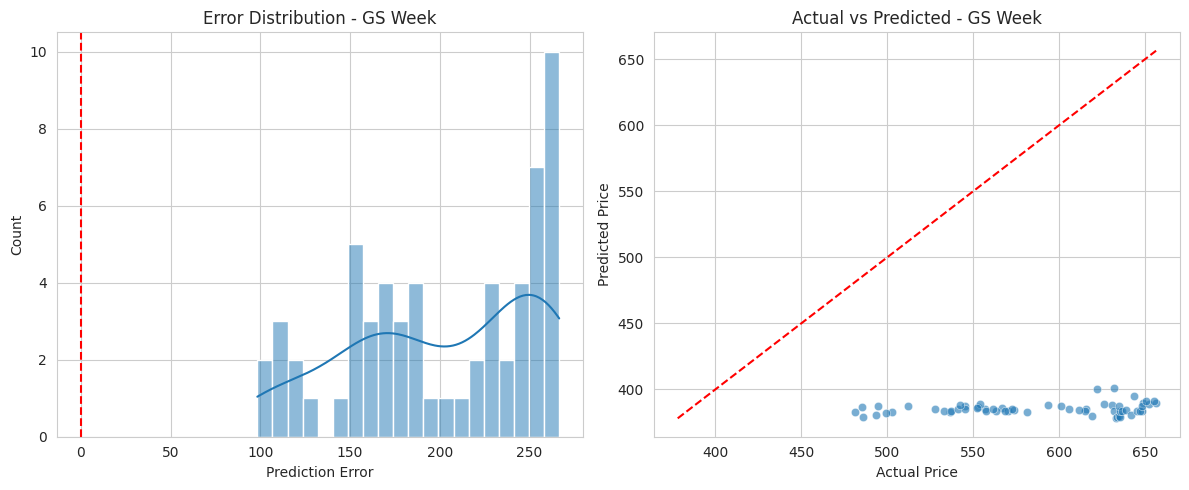


Evaluating GS month model...

Performance metrics for GS month model:
MSE: 37215.2428
RMSE: 192.9125
MAE: 186.3304
R2: -16.0148
MAPE: 32.0324
Direction Accuracy: 51.6667


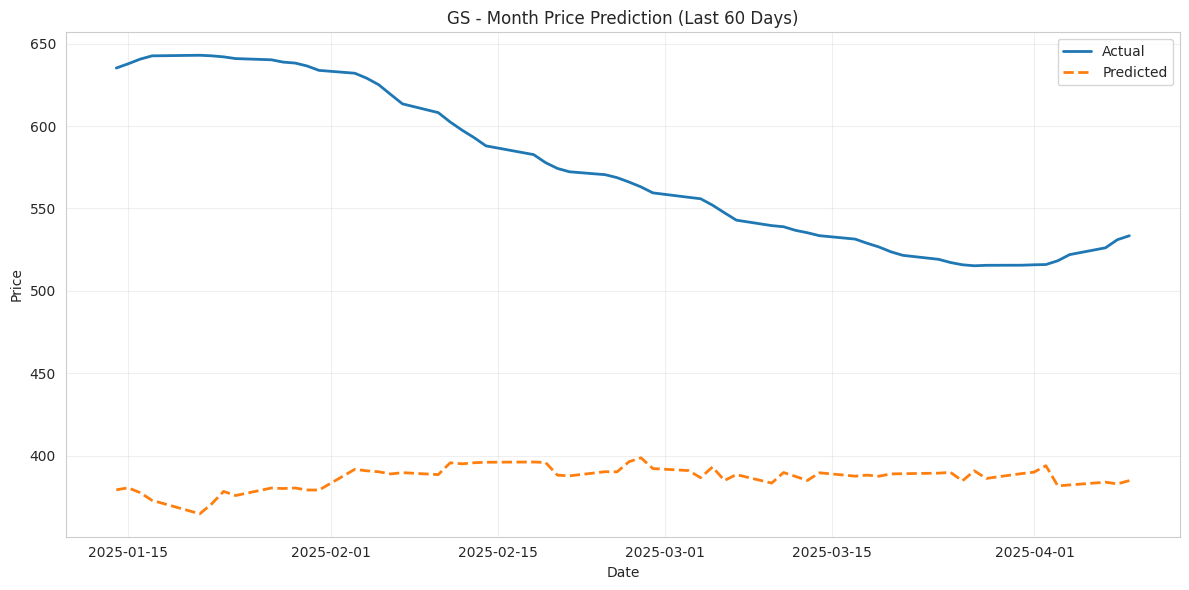

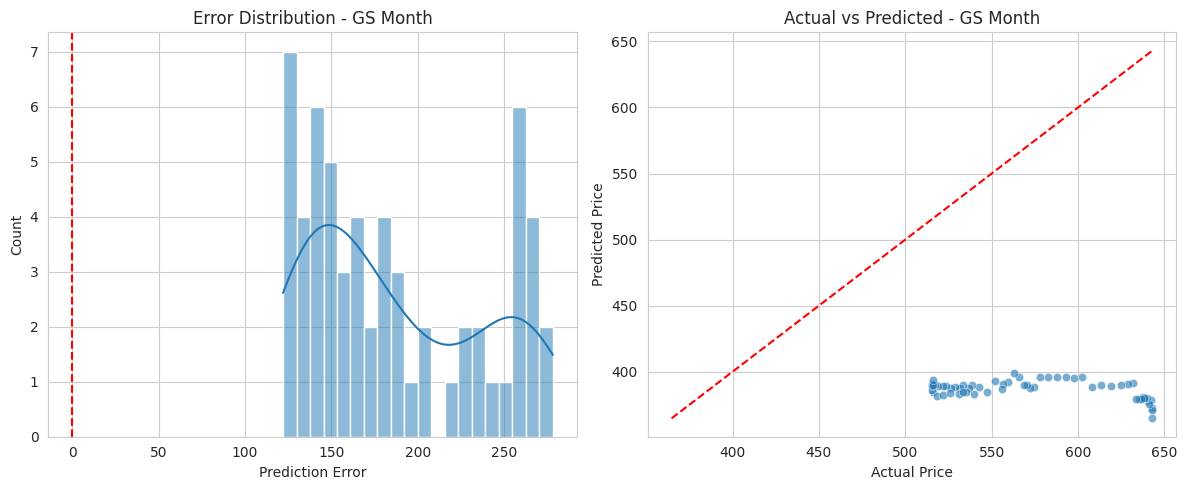


Model Evaluation Summary:
  Ticker Period        RMSE         MAE         R2       MAPE  \
0      T    day    6.575411    6.323668 -13.604500  24.364374   
1      T   week    7.349181    7.125440 -21.845967  27.365817   
2      T  month    8.653737    8.507191 -74.435554  32.201720   
3    SPY    day   79.909739   75.333408  -7.589799  12.815945   
4    SPY   week   83.049687   78.913247  -8.601204  13.492886   
5    SPY  month   76.205554   72.308820  -8.627901  12.552442   
6     GS    day  209.100309  202.914997 -14.581184  33.820305   
7     GS   week  208.303858  201.577035 -14.278329  33.782988   
8     GS  month  192.912526  186.330369 -16.014792  32.032361   

   Direction Accuracy  
0           55.000000  
1           63.333333  
2           50.000000  
3           43.333333  
4           55.000000  
5           48.333333  
6           61.666667  
7           55.000000  
8           51.666667  


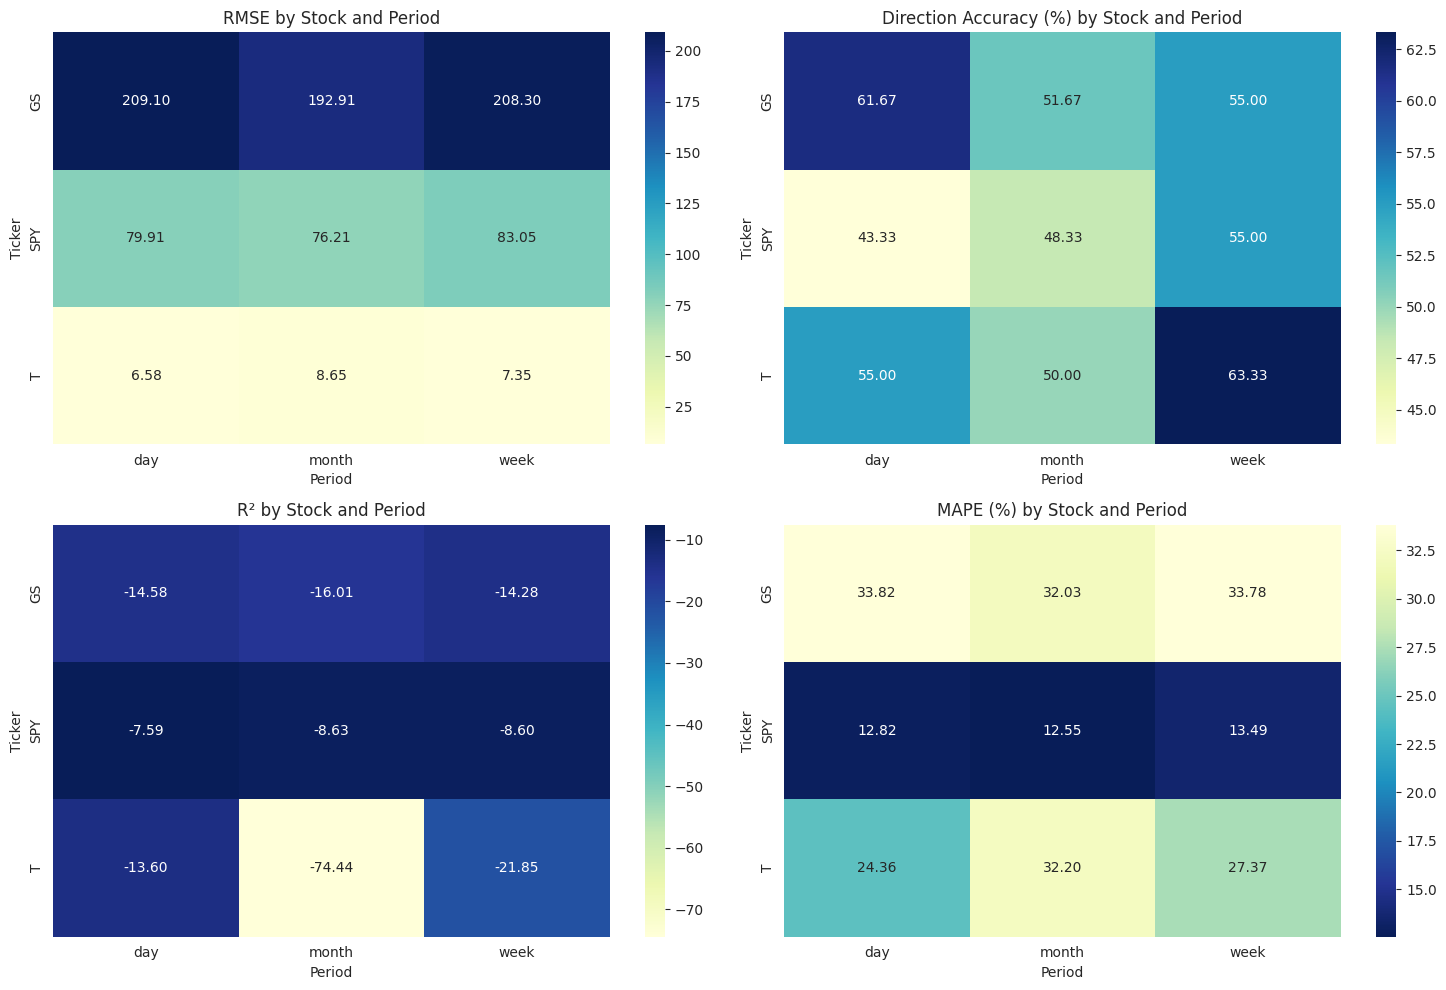


Average performance by prediction period:
             RMSE        MAE         R2       MAPE  Direction Accuracy
Period                                                                
day     98.528486  94.857357 -11.925161  23.666875           53.333333
month   92.590606  89.048793 -33.026082  25.595508           50.000000
week    99.567575  95.871907 -14.908500  24.880564           57.777778


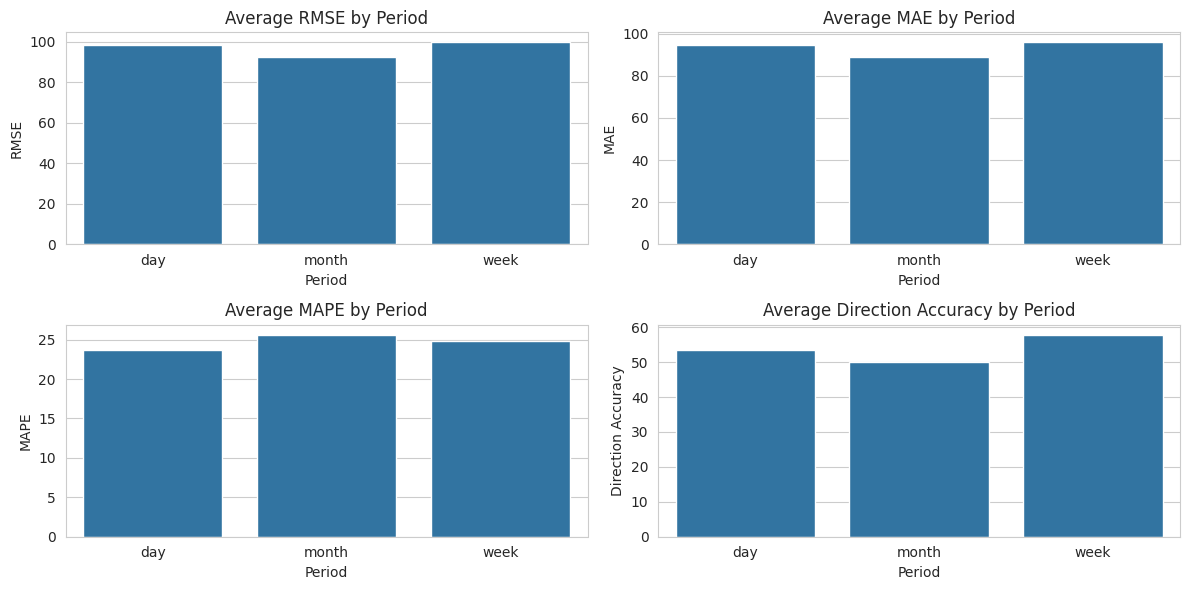

In [11]:
# Model Evaluation Cell
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model_performance(ticker, period, num_test_days=60):
    """
    Evaluate a trained model's performance on the most recent data points.
    
    Parameters:
    - ticker: Stock symbol
    - period: Prediction period (day, week, month)
    - num_test_days: Number of most recent days to use for testing
    
    Returns:
    - Dictionary of evaluation metrics
    """
    print(f"\nEvaluating {ticker} {period} model...")
    
    # Load the model
    model_path = os.path.join(output_dir, f"xgboost_{ticker}_{period}.joblib")
    model = joblib.load(model_path)
    
    # Load the features list
    features_path = os.path.join(output_dir, f"xgboost_{ticker}_{period}_features.txt")
    with open(features_path, 'r') as f:
        features = f.read().splitlines()
    
    # Get the data for this stock
    df = stock_data[ticker]
    
    # Get the target column for this period
    target_column = periods[period]
    
    # Use the last num_test_days days as test data
    test_data = df.iloc[-num_test_days:].copy()
    
    # Make predictions
    X_test = test_data[features]
    y_test = test_data[target_column]
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Calculate MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    # Calculate directional accuracy (up/down prediction accuracy)
    # This measures if the model correctly predicts price direction
    y_test_direction = np.sign(np.diff(y_test.values, prepend=y_test.values[0]))
    y_pred_direction = np.sign(np.diff(y_pred, prepend=y_pred[0]))
    direction_accuracy = np.mean(y_test_direction == y_pred_direction) * 100
    
    # Store metrics in dictionary
    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape,
        'Direction Accuracy': direction_accuracy
    }
    
    # Print metrics
    print(f"\nPerformance metrics for {ticker} {period} model:")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value:.4f}")
    
    # Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(test_data['date'], y_test, label='Actual', linewidth=2)
    plt.plot(test_data['date'], y_pred, label='Predicted', linewidth=2, linestyle='--')
    plt.title(f'{ticker} - {period.capitalize()} Price Prediction (Last {num_test_days} Days)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot error distribution
    errors = y_test - y_pred
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(errors, bins=20, kde=True)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.title(f'Error Distribution - {ticker} {period.capitalize()}')
    plt.xlabel('Prediction Error')
    
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
    # Add perfect prediction line (y=x)
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.title(f'Actual vs Predicted - {ticker} {period.capitalize()}')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    
    plt.tight_layout()
    plt.show()
    
    return metrics

# Define stocks to evaluate (you can select a subset to speed up the process)
stocks_to_evaluate = list(stock_data.keys())[:3]  # First 3 stocks, change as needed

# Store evaluation results
evaluation_results = {}

# Evaluate models for selected stocks
for ticker in stocks_to_evaluate:
    evaluation_results[ticker] = {}
    
    for period in periods:
        try:
            metrics = evaluate_model_performance(ticker, period)
            evaluation_results[ticker][period] = metrics
        except Exception as e:
            print(f"Error evaluating {ticker} {period} model: {str(e)}")

# Create a summary DataFrame
summary_rows = []
for ticker in evaluation_results:
    for period in evaluation_results[ticker]:
        metrics = evaluation_results[ticker][period]
        summary_rows.append({
            'Ticker': ticker,
            'Period': period,
            'RMSE': metrics['RMSE'],
            'MAE': metrics['MAE'],
            'R2': metrics['R2'],
            'MAPE': metrics['MAPE'],
            'Direction Accuracy': metrics['Direction Accuracy']
        })

summary_df = pd.DataFrame(summary_rows)

# Display summary table
print("\nModel Evaluation Summary:")
print(summary_df)

# Create visualization of the summary
plt.figure(figsize=(15, 10))

# Plot RMSE by stock and period
plt.subplot(2, 2, 1)
summary_pivot = summary_df.pivot(index='Ticker', columns='Period', values='RMSE')
sns.heatmap(summary_pivot, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('RMSE by Stock and Period')

# Plot Direction Accuracy by stock and period
plt.subplot(2, 2, 2)
summary_pivot = summary_df.pivot(index='Ticker', columns='Period', values='Direction Accuracy')
sns.heatmap(summary_pivot, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Direction Accuracy (%) by Stock and Period')

# Plot R2 by stock and period
plt.subplot(2, 2, 3)
summary_pivot = summary_df.pivot(index='Ticker', columns='Period', values='R2')
sns.heatmap(summary_pivot, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('R² by Stock and Period')

# Plot MAPE by stock and period
plt.subplot(2, 2, 4)
summary_pivot = summary_df.pivot(index='Ticker', columns='Period', values='MAPE')
sns.heatmap(summary_pivot, annot=True, cmap='YlGnBu_r', fmt='.2f')  # Reversed colormap since lower is better
plt.title('MAPE (%) by Stock and Period')

plt.tight_layout()
plt.show()

# Compare average performance across prediction periods
numeric_cols = ['RMSE', 'MAE', 'R2', 'MAPE', 'Direction Accuracy']
period_avg = summary_df.groupby('Period')[numeric_cols].mean()
print("\nAverage performance by prediction period:")
print(period_avg)

plt.figure(figsize=(12, 6))
metrics_to_plot = ['RMSE', 'MAE', 'MAPE', 'Direction Accuracy']

for i, metric in enumerate(metrics_to_plot):
    plt.subplot(2, 2, i+1)
    sns.barplot(x=period_avg.index, y=metric, data=period_avg)
    plt.title(f'Average {metric} by Period')
    plt.ylabel(metric)

plt.tight_layout()
plt.show()

## Understanding the Sliding Window Approach

The sliding window approach used in this notebook is a more realistic way to evaluate time series models. Here's what makes it effective:

### How it works:
1. **Initial Training**: We start by training on the first 90% of available data
2. **Window Size**: We use a 30-day prediction window, which means we're looking at how the model performs over the next 30 days
3. **Chronological Order**: The data is kept in strict chronological order, as is required for time series data

### Advantages of the sliding window approach:
- **More realistic evaluation**: Traditional train/test splits don't account for the sequential nature of financial data
- **Handles market regime changes**: By sliding through time, we can see how the model performs across different market conditions
- **Prevents leakage**: Ensures that we're not using future data to predict the past

### XGBoost Configuration:
We've configured XGBoost for different prediction horizons:

1. **Day prediction**:
   - Higher learning rate (0.05)
   - Fewer estimators (200)
   - Medium tree depth (6)

2. **Week prediction**:
   - Medium learning rate (0.03)
   - More estimators (300)
   - Medium tree depth (6)

3. **Month prediction**:
   - Lower learning rate (0.02)
   - Most estimators (400)
   - Lower tree depth (5)
   - More conservative sampling parameters (0.7)

These parameters are designed to balance between short-term reactivity (for day predictions) and avoiding overfitting for longer-term predictions (month).

## Feature Engineering Explanation

The features we're using for the XGBoost models were created during the data preparation phase. Here's an explanation of the key feature groups:

### 1. Price-based features
- **close**: Closing price, essential baseline information
- **return**: Daily percentage return, indicates daily movement
- **price_change_pct**: Percentage change in price from previous day
- **daily_range_pct**: Daily trading range as percentage of opening price, indicates volatility
- **price_position**: Where closing price sits within day's range (0 = at low, 1 = at high), indicates buying/selling pressure

### 2. Trend indicators
- **dist_from_ma5/20/50**: Distance of price from various moving averages, shows trend alignment
- **ma5_gt_ma20**, **ma20_gt_ma50**: Binary indicators of moving average crossovers, classic trend signals

### 3. Volume indicators
- **volume_change**: Percentage change in volume, indicates changing interest
- **relative_volume**: Current volume compared to 20-day average, shows abnormal activity

### 4. Momentum indicators
- **momentum_3d/5d/10d**: Price changes over different time periods, captures momentum trends

### 5. Technical indicators
- **rsi_14**: Relative Strength Index (momentum oscillator, 0-100), identifies overbought/oversold conditions
- **bb_width**: Bollinger Band width, measures volatility expansion/contraction
- **bb_position**: Where price is within Bollinger Bands (0-1), statistical position

### 6. Lag features
- **prev_close/volume/return**: Previous day's values, provides sequential context

### 7. Cyclical time features
- **day_of_week_sin/cos**, **month_sin/cos**: Cyclical encoding of time features, captures seasonality

These diverse features help XGBoost learn different aspects of stock behavior, from price trends and momentum to volatility and seasonality, allowing for more accurate predictions across different time horizons.

## Conclusion and Next Steps

We have successfully trained XGBoost models using a sliding window approach for 3 different prediction periods (day, week, month) for each stock. 

### Key Achievements:
1. Implemented a sliding window approach for more realistic training and evaluation
2. Trained specialized XGBoost models for each stock and time horizon
3. Optimized model parameters for different prediction periods
4. Saved models, feature importance, and feature lists for future use
5. Utilized the CPU efficiently with n_jobs=-1 for parallel processing

### Output Files:
For each stock and prediction period, the following files have been saved:
- `xgboost_TICKER_PERIOD.joblib`: The trained model
- `xgboost_TICKER_PERIOD_importance.csv`: Feature importance rankings
- `xgboost_TICKER_PERIOD_features.txt`: List of features used for the model

### Next Steps:
1. **Model evaluation**: Create separate notebooks for detailed model evaluation
2. **Prediction pipeline**: Implement a pipeline to use these models for real-time forecasting
3. **Model comparisons**: Compare XGBoost performance with other models (LSTM, Prophet)
4. **Ensemble approaches**: Consider combining multiple models for improved performance

### Usage Example:
To use the trained models for prediction:

```python
import joblib
import pandas as pd

# Load model
model = joblib.load('../model/xgboost/xgboost_AAPL_day.joblib')

# Load feature list
with open('../model/xgboost/xgboost_AAPL_day_features.txt', 'r') as f:
    features = f.read().splitlines()

# Load new data
new_data = pd.read_csv('new_data.csv')

# Make predictions
predictions = model.predict(new_data[features])
```